In [1]:
import pandas as pd 
import numpy as np 
import pingouin as pg 
import seaborn as sns
import matplotlib.pyplot as plt
from pingouin import linear_regression
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import MinMaxScaler

# Part B: Mahalanobis distance

This noteook consists of theps required to run the PartB analysis. Overall goal is to compute individual per bundle distance of the preterm population to the population of controls. <br>
Steps:<br>

We need to treat the preterm and control populations separately - this is because the distance should be calculated to the adjusted control population/correted variability - to remove the negative values => +/- residuals from the mean over all controls. <br>

Afterwards, study the linear relationships of mahalanobis distance with age at birth (corrected for preterm confounders). 


In [6]:
def get_clinical_variables(iFile='../../DerivedData/Global.csv'):
    clinic = pd.read_csv(iFile, sep=';')
    
    #to_keep = ['ParticipantID', 'FetalGrowthRestriction', 'ParenteralNutrition>21d', 'Pregnancy-size', 
    #      'Sex', 'Gabirth', 'PMA-MRI']
    
    #to_keep = ['ParticipantID', 'FetalGrowthRestriction', 'Gabirth', 'PMA-MRI']
    to_keep = ['ParticipantID', 'Gabirth', 'PMA-MRI']
    clinic = clinic[to_keep]
    clinic.rename( columns ={
                'ParticipantID' : 'subject_id',
                'ParenteralNutrition>21d' : 'ParenteralNutrition',
                'Pregnancy-size' : 'PregnancySize', 
                'Gabirth' : 'birth_age',
                'PMA-MRI' : 'scan_age'
                }, inplace=True)
    
    ## correct excel commas in floats
    for col in ['birth_age', 'scan_age']:
        clinic[col] = clinic[col].astype(str)
        clinic[col] = clinic[col].apply(lambda x: x.replace(',','.'))
        clinic[col] = clinic[col].astype(np.float16)
        
    ### categorize what needs to be categorized

    #for col in ['ParenteralNutrition','PregnancySize', 'FetalGrowthRestriction', 'Sex']:
    #for col in [ 'FetalGrowthRestriction']:
    #    clinic[col] = clinic[col].astype('category')
    #    clinic[col] = clinic[col].cat.codes
   
    return clinic


def _get_meanWM(group):
    

    ex_WM = pd.read_csv('../../DerivedData/extreme_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)
    mod_WM = pd.read_csv('../../DerivedData/moderate_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)

    WM = pd.concat([ex_WM, mod_WM])
    WM.rename(columns={'matched_ID' : 'control_ID'}, inplace=True)
        
    cols = [col for col in WM.columns if group in col]
    cols = [col for col in cols if 'post' not in col]
        
    WM = WM[cols]
    WM = WM.set_axis(['meanWM_'+col.split('_')[1] for col in cols] , axis=1, inplace=False)
    WM.reset_index(drop=True, inplace=True)
    WM.rename(columns={'meanWM_ID': 'subject_id'}, inplace =True)
    
    return WM 
        
def import_WM():
    
    preterm_WM = _get_meanWM('preterm')
    control_WM = _get_meanWM('control')

    WM = pd.concat([preterm_WM, control_WM])
    return WM


def _min_max_scale(X, range):
    mi, ma = range
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (ma - mi) + mi
    return X_scaled

def scale_over_metrics(df, metrics, range=(0,1)):
    
    df = df.copy()
    
    for metric in metrics:
        features = [col for col in df.columns if metric in col]
        df[features] = _min_max_scale(df[features].values, range=range)
    

    return df

In [7]:
### the bundles of interest, fix the ordering for plots 
## to fix the ordering for plots 
pair_names = [
    'M1-Brainstem', 'S1-Brainstem','Paracentral-Brainstem',
    'M1-Caud', 'S1-Caud','Paracentral-Caud',
    'M1-Lenti', 'S1-Lenti','Paracentral-Lenti', 
    'M1-Thalfus', 'S1-Thalfus','Paracentral-Thalfus', 
    'M1L-M1R', 'S1L-S1R',
    'S1-M1' ]

metrics = ['AD', 'RD', 'FA', 'MD', 'NDI', 'ODI']

#sets = [['AD','RD', 'FA', 'MD'], ['NDI', 'ODI']]
#set_names = ['set1', 'set2']

sets = [['AD','RD'], ['FA', 'MD'], ['NDI', 'ODI']]
set_names = ['set1', 'set2', 'set3']

## 1. Read in and pre-process the data 

In [8]:
## first deal with the control population (take only the matches!)
controls = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_control_group_mergedLR.csv', index_col=0)
preterms = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_preterm_group_mergedLR.csv', index_col=0)

# the airing - as there is fewer preterms, use their IDs to find matches with controls 
matched = pd.read_csv('../../DerivedData/subject_matching.csv', index_col=0)
matched = matched[matched['preterm_ID'].isin(preterms['subject_id'].values)]

#get matched controls
controls = controls[controls.subject_id.isin(matched.matched_ID_with_outcome.values)]
df = pd.concat([preterms, controls])

### GET MEAN WM 
df = pd.merge(df,  import_WM(), how='inner', on=['subject_id'])

### SCALE OVER metrics 
df = scale_over_metrics(df, metrics=metrics, range=(0,1))

### get clinical variables 
df = pd.merge(df,  get_clinical_variables(), how='inner', on=['subject_id']) 


## 2. Separate into control and preterm groups 

In [11]:
control_ids = controls.subject_id.values
preterm_ids = preterms.subject_id.values

controls = df[df.subject_id.isin(control_ids)].copy()
preterms = df[df.subject_id.isin(preterm_ids)].copy()


## 3. Correct metric values 

Controls - correct for scan age, birth age, and residual WM <br>
preterms - correct for scan age, and residual WM 

In [12]:
def correct_metrics(df, metrics, bundles, group):
    
    df= df.copy()
    temp = df.copy()
    
    for metric in metrics:
        temp['residual_WM_' + metric] = _get_WM_residuals(df=temp, metric=metric)
        
        for bundle in bundles:
            
            if group == 'control':
                
                df[bundle + '_' + metric] = _get_metric_residuals_ct(df=temp, bundle=bundle, metric=metric)
            else: 
                df[bundle + '_' + metric] = _get_metric_residuals_pt(df=temp, bundle=bundle, metric=metric)
           
    return df
    
        

def _get_WM_residuals(df, metric):
    from pingouin import linear_regression
    df = df.copy()
    
    df['scan_age'] = np.float32(df['scan_age'].values)
    df['birth_age'] = np.float32(df['birth_age'].values)
    df['meanWM_' + metric] = np.float32(df['meanWM_' + metric].values)
    
    lm = linear_regression( X= df[['scan_age', 'birth_age']], y = df['meanWM_' + metric])
    #lm = linear_regression( X= df['scan_age'], y = df['meanWM_' + metric])
    return lm.residuals_
    
def _get_metric_residuals_ct(df, bundle, metric):
    
    from pingouin import linear_regression
    df = df.copy()
    
    df[bundle+'_'+ metric] = np.float32(df[bundle+'_'+ metric].values)
    df['scan_age'] = np.float32(df['scan_age'].values)
    df['birth_age'] = np.float32(df['birth_age'].values)
    df['residual_WM_' + metric] = np.float32(df['residual_WM_' + metric].values)
    
    correction = ['scan_age', 'birth_age', 'residual_WM_' + metric]
    
    mean = np.mean(df[bundle+'_'+metric].values)
    
    lm = linear_regression( X= df[correction], y = df[bundle+'_'+ metric])
    
    return lm.residuals_ + mean

def _get_metric_residuals_pt(df, bundle, metric):
    
    from pingouin import linear_regression
    df = df.copy()
    
    df[bundle+'_'+ metric] = np.float32(df[bundle+'_'+ metric].values)
    df['scan_age'] = np.float32(df['scan_age'].values)
    df['birth_age'] = np.float32(df['birth_age'].values)
    df['residual_WM_' + metric] = np.float32(df['residual_WM_' + metric].values)
    
    correction = ['scan_age',  'residual_WM_' + metric]
    
    mean = np.mean(df[bundle+'_'+metric].values)
    
    lm = linear_regression( X= df[correction], y = df[bundle+'_'+ metric])
    
    return lm.residuals_ + mean
    
    

In [13]:
preterm_cor = correct_metrics(df=preterms, metrics=metrics, bundles=pair_names, group='preterm')
control_cor = correct_metrics(df=controls, metrics=metrics, bundles=pair_names, group='control')

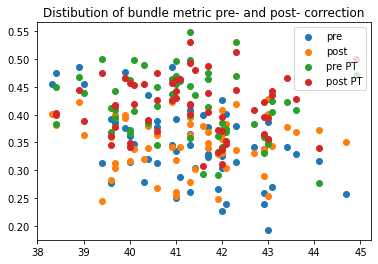

In [18]:
## sanity check 
plt.title('Distibution of bundle metric pre- and post- correction')
plt.scatter(controls['scan_age'], controls['S1-Brainstem_AD'], label='pre')
plt.scatter(control_cor['scan_age'], control_cor['S1-Brainstem_AD'], label='post')


plt.scatter(preterms['scan_age'], preterms['S1-Brainstem_AD'], label='pre PT')
plt.scatter(preterm_cor['scan_age'], preterm_cor['S1-Brainstem_AD'], label='post PT')


plt.legend()
plt.show()

## 4. Compute Mahalanobis 

In [19]:
def get_mahalanobis_bundles(effect_group, control_group, bundles, sets, set_names):
    mah_results = pd.DataFrame()
    
    for bundle in bundles:
        for subset, name in zip(sets, set_names):
            features = np.array([bundle+'_'+metric for metric in subset])
           
            control_ar = control_group[features]
            ### normalize by mean 
            mean_control = np.mean(control_ar, axis=0)
            control_ar = (control_ar / mean_control)
            
            ## get inverse covariance matrix for the control group 
            corr = np.cov(control_ar.T)
            corrI = np.linalg.inv(corr)
            
            distances = []
            for i, preterm in enumerate(effect_group.subject_id.values):
                subj_vect = effect_group[effect_group.subject_id == preterm][features].values[0]
                subj_vect = (subj_vect / mean_control)# / range_control
                cont_vect = np.mean(control_ar, axis=0) 
                
                mh = mahalanobis(u = subj_vect, v = cont_vect, VI=corrI)
                
                mah_results.loc[i,'subject_id'] = preterm
                mah_results.loc[i, bundle+'_mh_'+name] = mh
            
    return mah_results

In [20]:
mh_results = get_mahalanobis_bundles(effect_group=preterm_cor, control_group=control_cor, bundles=pair_names, sets=sets, set_names=set_names)

## 5. Linear relationship of mahalanobis with age 

In [23]:
mh = pd.merge(mh_results, preterms[['subject_id', 'scan_age', 'birth_age']], on='subject_id', how='inner')

In [57]:
### COMPUTE THE LINEAR REGRESSION WITH AGE 
results = pd.DataFrame()


for bundle in pair_names:
    for i, subset in enumerate(['set1', 'set2', 'set3']):
    #for i, subset in enumerate(['set1']):
        
        test= pg.linear_regression(X = mh['birth_age'], 
                                   y = mh[bundle+'_mh_'+subset])
        
        test2 = pg.linear_regression(X = mh['birth_age'], 
                                   y = mh[bundle+'_mh_'+subset], as_dataframe=False)

        results.loc[i, 'set'] = subset
        results.loc[i, bundle] = np.float64(test['pval'][1])
        #results.loc[i, bundle] = np.round(np.float64(test['coef'][1]),3)
    #results_T.loc[i, new_col+'_T'] = np.round(np.float64(test['T'][1]),2)
    #results_T.loc[i, new_col+'_slope'] = np.float64(test['coef'][1])

        
results[results.columns[1:]] = results[results.columns[1:]].astype(np.float64)

pre_p = results[results.columns[1:]].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(results[results.columns[1:]].values))

results[results.columns[1:]] = pvals_corr

In [28]:
colors = {'Brainstem' : 'forestgreen',
          'Caud' : 'darkmagenta', 
          'Lenti': 'blue', 
         'Thalfus': 'gray', 
          'M1R' : 'magenta', 
          'S1R' : 'magenta',
          'M1': 'teal',
         'S1': 'teal'}

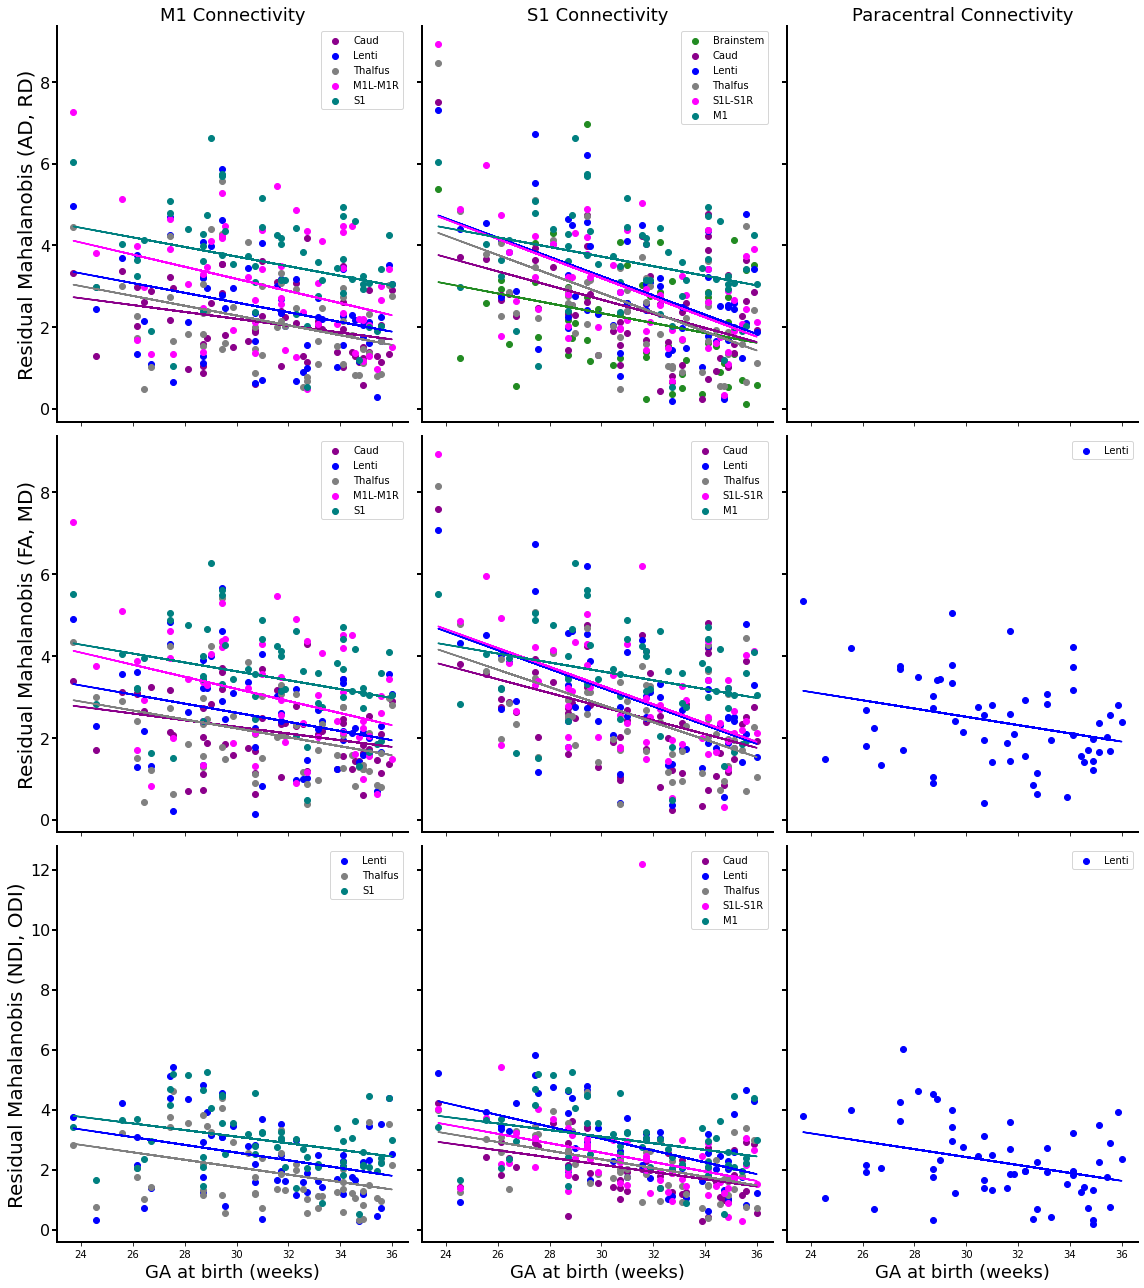

In [43]:
pairs = pair_names

fig, axs = plt.subplots(3,3, figsize=(16,18), sharex=True, sharey='row')


for i, subset in enumerate(['set1', 'set2', 'set3']):
    for pair in pairs: 
                        
        #print(name)
        

        if  pair in ['M1-Brainstem', 'M1-Caud', 'M1-Lenti', 'M1-Thalfus', 'M1L-M1R', 'S1-M1']:
            ax_idx = 0
            
            if pair == 'S1-M1':
                label = pair.split('-')[0]
            elif pair == 'M1L-M1R':
                label = pair
            else: 
                label = pair.split('-')[1]
            
            if results[results.set == subset][pair].values[0] < 0.05:
                
                axs[i,ax_idx].scatter( mh['birth_age'].values, mh[pair +'_mh_'+subset].values, 
                             c = colors[pair.split('-')[1]], label=label)
                
                
                m, b = np.polyfit(np.float32(mh['birth_age'].values), np.float32(mh[pair +'_mh_'+subset].values), 1)
                axs[i,ax_idx].plot(mh['birth_age'].values, 
                                  m* mh['birth_age'].values + b, 
                                 c = colors[pair.split('-')[1]])
                axs[i,ax_idx].legend(loc='upper right')#, bbox_to_anchor=(1.5, 0.5))
                  
        
        #axs[i,ax_idx].legend(loc='upper right')    
        
            
        if pair in ['S1-Brainstem', 'S1-Caud', 'S1-Lenti', 'S1-Thalfus', 'S1L-S1R', 'S1-M1']: 
            ax_idx = 1
            
            if pair == 'S1L-S1R':
                label = pair
            else: 
                label = pair.split('-')[1]
            
            if results[results.set == subset][pair].values[0] < 0.05:
                
                axs[i,ax_idx].scatter( mh['birth_age'].values, mh[pair +'_mh_'+subset].values, 
                             c = colors[pair.split('-')[1]], label=label)
                
                
                m, b = np.polyfit(np.float32(mh['birth_age'].values), np.float32(mh[pair +'_mh_'+subset].values), 1)
                axs[i,ax_idx].plot(mh['birth_age'].values, 
                                  m* mh['birth_age'].values + b, 
                                 c = colors[pair.split('-')[1]])
                axs[i,ax_idx].legend(loc='upper right')#, bbox_to_anchor=(1.5, 0.5))
                
        if pair in ['Paracentral-Brainstem', 'Paracentral-Caud', 'Paracentral-Lenti', 'Paracentral-Thalfus']: 
            ax_idx = 2
            label = pair.split('-')[1]
            
            if results[results.set == subset][pair].values[0] < 0.05:
                
                axs[i,ax_idx].scatter( mh['birth_age'].values, mh[pair +'_mh_'+subset].values, 
                             c = colors[pair.split('-')[1]], label=label)
                
                
                m, b = np.polyfit(np.float32(mh['birth_age'].values), np.float32(mh[pair +'_mh_'+subset].values), 1)
                axs[i,ax_idx].plot(mh['birth_age'].values, 
                                  m* mh['birth_age'].values + b, 
                                 c = colors[pair.split('-')[1]])
                axs[i,ax_idx].legend(loc='upper right')#, bbox_to_anchor=(1.5, 0.5))  

    
for i in range(3):
    axs[2,i].set_xlabel('GA at birth (weeks)', fontsize=18)
    
axs[0,0].set_title('M1 Connectivity', fontsize=18)
axs[0,1].set_title('S1 Connectivity', fontsize=18)
axs[0,2].set_title('Paracentral Connectivity', fontsize=18)

axs[0,0].set_ylabel('Residual Mahalanobis (AD, RD)', fontsize=20)
axs[1,0].set_ylabel('Residual Mahalanobis (FA, MD)', fontsize=20)
axs[2,0].set_ylabel('Residual Mahalanobis (NDI, ODI)', fontsize=20)

fig.patch.set_facecolor('white')

#axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), 
#           ncol = 4, fontsize=18, frameon=False, markerscale=0.6)   

for i in range(3):
    for j in range(3):
        # Hide the right and top spines
        axs[i,j].spines['right'].set_visible(False)
        axs[i,j].spines['top'].set_visible(False)
        for axis in ['bottom','left']:
            axs[i,j].spines[axis].set_linewidth(2)
        
        axs[i,j].tick_params(axis='y', labelsize=16)    
        plt.setp(axs[i,j].yaxis.get_ticklines(), 'markeredgewidth', 2)
        plt.setp(axs[i,j].yaxis.get_ticklines(), 'markersize', 5)

        
plt.tight_layout()
plt.show()